**Goal:** To understand the building blocks of a Transformer and the impact of its attention mechanism.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)

From attention → Transformer block

x → Attention → + residual → LayerNorm
  → FFN       → + residual → LayerNorm

Reusable scaled dot-product attention

In [2]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    d = Q.size(-1)
    scores = Q @ K.T / np.sqrt(d)
    if mask is not None:
        scores = scores + mask
    weights = torch.softmax(scores, dim=-1)
    return weights @ V, weights

Single-head self-attention module (manual QKV)

In [3]:
class SelfAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x, mask=None):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)
        out, attn = scaled_dot_product_attention(Q, K, V, mask)
        return out, attn

Add residual + LayerNorm → attention sublayer

In [4]:
class AttentionBlock(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.attn = SelfAttention(d_model)
        self.ln = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        attn_out, attn_weights = self.attn(x, mask)
        x = self.ln(x + attn_out)
        return x, attn_weights

Add FFN → full Transformer block

In [5]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.attn_block = AttentionBlock(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.ln = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        x, attn = self.attn_block(x, mask)
        ffn_out = self.ffn(x)
        x = self.ln(x + ffn_out)
        return x, attn

Stack blocks → mini-former

In [6]:
class MiniFormer(nn.Module):
    def __init__(self, n_layers, d_model, d_ff):
        super().__init__()
        self.layers = nn.ModuleList(
            [TransformerBlock(d_model, d_ff) for _ in range(n_layers)]
        )

    def forward(self, x, mask=None):
        attns = []
        for layer in self.layers:
            x, attn = layer(x, mask)
            attns.append(attn)
        return x, attns

Run on toy data

In [7]:
seq_len = 6
d_model = 8
d_ff = 32
n_layers = 3

x = torch.randn(seq_len, d_model)

model = MiniFormer(n_layers, d_model, d_ff)
out, attns = model(x)

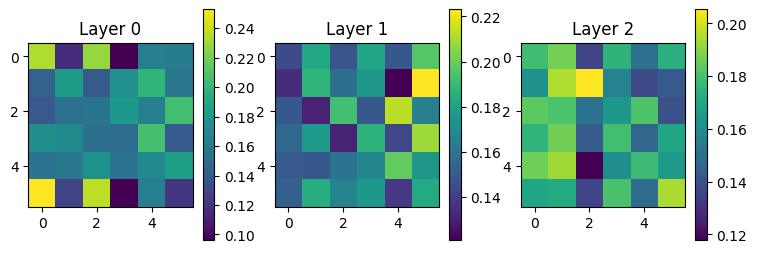

In [8]:
plt.figure(figsize=(9,3))

for i, attn in enumerate(attns):
    plt.subplot(1, n_layers, i+1)
    plt.imshow(attn.detach())
    plt.title(f"Layer {i}")
    plt.colorbar()

plt.show()

Break Q, K, V on purpose

In [9]:
#Swap Q and K
class BrokenAttention(SelfAttention):
    def forward(self, x, mask=None):
        Q = self.Wk(x)   # swapped
        K = self.Wq(x)
        V = self.Wv(x)
        out, attn = scaled_dot_product_attention(Q, K, V, mask)
        return out, attn

In [14]:
normal_attn = SelfAttention(d_model)
broken_attn = BrokenAttention(d_model)

out_ok, attn_ok = normal_attn(x)
out_bad, attn_bad = broken_attn(x)

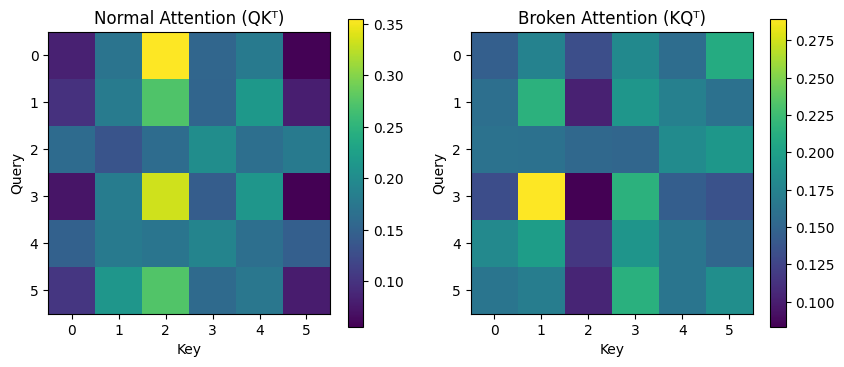

In [15]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(attn_ok.detach())
plt.title("Normal Attention (QKᵀ)")
plt.xlabel("Key")
plt.ylabel("Query")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(attn_bad.detach())
plt.title("Broken Attention (KQᵀ)")
plt.xlabel("Key")
plt.ylabel("Query")
plt.colorbar()

plt.show()

In [10]:
#Replace V with K
class NoValueAttention(SelfAttention):
    def forward(self, x, mask=None):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = K  # wrong!
        out, attn = scaled_dot_product_attention(Q, K, V, mask)
        return out, attn

In [16]:
normal_attn = SelfAttention(d_model)
novalue_attn = NoValueAttention(d_model)

out_ok, attn_ok = normal_attn(x)
out_bad, attn_bad = novalue_attn(x)

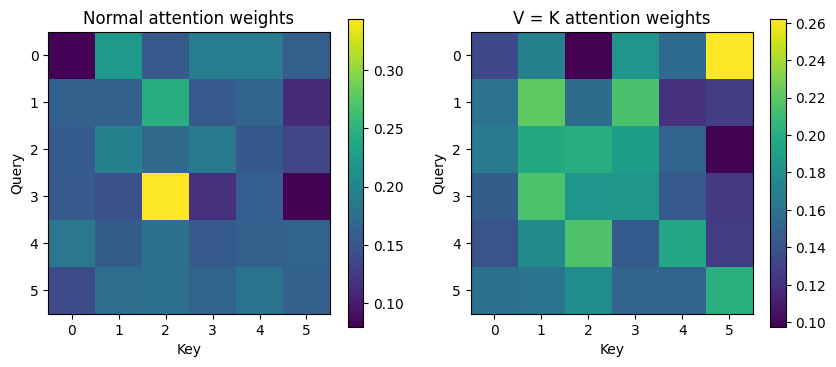

In [17]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(attn_ok.detach())
plt.title("Normal attention weights")
plt.xlabel("Key")
plt.ylabel("Query")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(attn_bad.detach())
plt.title("V = K attention weights")
plt.xlabel("Key")
plt.ylabel("Query")
plt.colorbar()

plt.show()

In [11]:
#Zero out Q
class ZeroQueryAttention(SelfAttention):
    def forward(self, x, mask=None):
        Q = torch.zeros_like(self.Wq(x))
        K = self.Wk(x)
        V = self.Wv(x)
        out, attn = scaled_dot_product_attention(Q, K, V, mask)
        return out, attn

In [18]:
normal_attn = SelfAttention(d_model)
zeroq_attn = ZeroQueryAttention(d_model)

out_ok, attn_ok = normal_attn(x)
out_zero, attn_zero = zeroq_attn(x)

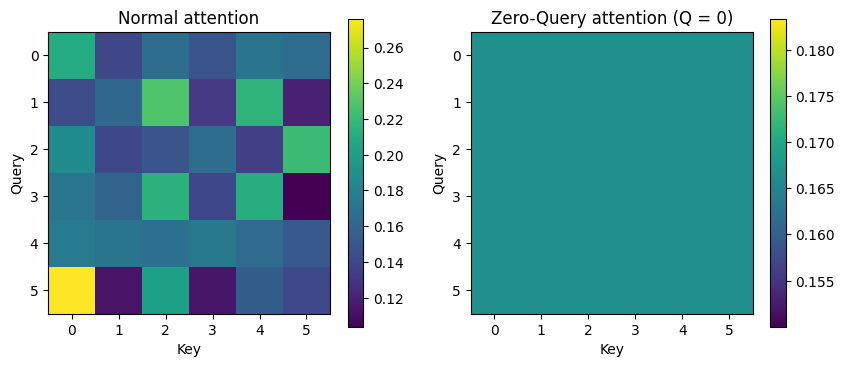

In [19]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(attn_ok.detach())
plt.title("Normal attention")
plt.xlabel("Key")
plt.ylabel("Query")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(attn_zero.detach())
plt.title("Zero-Query attention (Q = 0)")
plt.xlabel("Key")
plt.ylabel("Query")
plt.colorbar()

plt.show()

##Notebook Summary

**Achieved:**



*   Implementing a mini-Transformer model from basic attention to a full stack of Transformer blocks.
*   Demonstrating its functionality with toy data to visualize attention weights.
*   Analyzing the effects of 'broken' attention mechanisms (swapping Q/K, replacing V with K, zeroing out Q) through visual comparisons of attention weights.

**Result:** Observed how different configurations of the query, key, and value matrices drastically alter the attention patterns, highlighting the critical role each component plays in the Transformer's self-attention mechanism.